<a href="https://colab.research.google.com/github/Sparrow0hawk/ittt-ai-ml-dl/blob/session3-AC/session_3_topicsML/session3_unsup_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src=https://raw.githubusercontent.com/ARCLeeds/arcleeds.github.io/master/assets/img/lighterblueText_wLogo_m2.1.png alt="Research Computing logo" style="width:900px;">

# IT TechTalk - Session 2: Text analysis approaches

## Agenda

- [Introduction](#Introduction)
- [LDA Primer](#LDA-Primer)
- [Preprocessing](#Preprocessing)
- [Build a Bag of words corpus](#Building-a-bag-of-words-corpus-and-dictionary)
- [Building a topic model](#Building-the-topic-model)

## Introduction

Text analysis is a classic computational and data science problem.

![NLP](https://deeplearninganalytics.org/wp-content/uploads/2019/04/nlp.png)

Compared with regression and classification approaches on continuous and categorical dataset taking text data and deriving distinct insights is a far more complicated task. Text data and especially free text (text fields in sentence form) is typically classed as a form of unstructured data because of the various nuances introduced by languages.

With the ever increasing computational power has come a side-by-side improvements in approaches to text analysis. 

There are a number of different approaches to text analysis such as sentiment analysis, machine translation, information retrieval and much more. In this talk we'll focus specifically on **topic modelling**. An unsupervised statistical approach for identifying abstract 'topics' from within a collection of documents (corpus).

We'll look specifically at latent Dirichlet allocation (LDA), a topic modelling approach developed in [2002](http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA has become one of the most commonly used topic modelling approaches and many extensions of LDA have since been proposed.

We'll use financial complaints data from the [US Consumer Financial Protection Bureau](https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data) for this example.

## LDA Primer

A quick example running through how LDA determines topics.

Imagine we had these sentences within one document:
```
  1. I spent the day walking outside.
  2. I visited the Yorkshire Dales.
  3. I spent the day visiting the Yorkshire Dales.
```

LDA might determine the topic share of each sentence thus:
```
  1. 100% Topic 1
  2. 100% Topic 2
  3. 20% Topic 1 and 80% Topic 2
```

LDA also discovers what words make us those topics:
```
  1. Topic 1: 30% walking, 20% day, 10% outside (relate to walking outside)
  2. Topic 2: 40% Yorkshire, 30% Dales, 20% visiting (relate to Yorkshire dales)
```


## Data Loading

Let's start by loading in the dataset and having a quick look at it.

In [21]:
# line wrapping for colab https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
!pip install gensim==3.8.0
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

     |████████████████████████████████| 24.2MB 68.8MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


We add some shell scripting here to create a data directory and download and unzip our data file.

In [3]:
%%bash 

if [ -d data/ ]; then
    echo "Data directory exists"
else
    mkdir data
fi

if test -f data/complaints.csv; then
    echo "Data file exists"
else 
    curl -LO http://files.consumerfinance.gov/ccdb/complaints.csv.zip; mv complaints.csv.zip data/ ;unzip data/complaints.csv.zip -d data/
fi

Archive:  data/complaints.csv.zip
  inflating: data/complaints.csv     


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   183  100   183    0     0    693      0 --:--:-- --:--:-- --:--:--   693
100  263M  100  263M    0     0  25.4M      0  0:00:10  0:00:10 --:--:-- 28.5M


Next we load this dataset into a pandas DataFrame python object. This is alot like a spreadsheet and allows for easy manipulation of columns and rows.

In [4]:
# import the dataset

ticket_data = pd.read_csv('data/complaints.csv')

ticket_data.dropna(subset=["Consumer complaint narrative"], inplace=True)

print(ticket_data.shape)

ticket_data.head()

(578500, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
7,2019-09-08,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"I was sold access to an event digitally, of wh...",NaN,"Paypal Holdings, Inc",RI,029XX,NaN,Consent provided,Web,2019-09-08,Closed with explanation,Yes,NaN,3366475
8,2019-03-05,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,This complaint dates back to last XX/XX/XXXX d...,NaN,NATIONSTAR MORTGAGE,FL,339XX,NaN,Consent provided,Web,2019-03-11,Closed with explanation,Yes,NaN,3170293


In [5]:
# simple data exploration looking at the different number of complaints in each Product category
ticket_data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    193257
Debt collection                                                                 119420
Mortgage                                                                         67573
Credit card or prepaid card                                                      40739
Credit reporting                                                                 31588
Student loan                                                                     26687
Checking or savings account                                                      23510
Credit card                                                                      18838
Bank account or service                                                          14885
Vehicle loan or lease                                                             9919
Money transfer, virtual currency, or money service                                9895
Consumer Loan                              

In [53]:
# a quick look at the average number of words in each complaint in each category
ticket_data.groupby('Product')['Consumer complaint narrative'].apply(lambda x: np.mean([len(word) for word in x]))

Product
Credit card    1127.125438
Name: Consumer complaint narrative, dtype: float64

In [7]:
ticket_data = ticket_data[ticket_data['Product'] == 'Credit card']

In [8]:
# lets peak and look what this looks like

ticket_data['Consumer complaint narrative'][:5].tolist()

['I was stupid enough to charge some items at MACY \'S on my Macy \'s credit card over XXXX. I was unable to log into my account online to make the payment because Macy \'s had updated the system and I simply did n\'t have the patience to navigate their irritating and obscure system. However, I called Macy \'s and paid my bill for $ XXXX a day or two late - was assured that there would be no late charges because I was a customer in good standing, yada yada, and received a confirmation number that I had paid the bill in full. \n\nI then received a bill for {$2.00} in interest. OK, I agree - I had n\'t paid the {$140.00} on time, regardless of the reason. Whatever. So I paid that {$2.00} bill immediately, by check, and left the country for an extended absence - in complete confidence that I had paid all my bills in full. \n\nImagine my surprise when I returned to the US and found that Macy \'s had received and cashed my check, but charged me a further {$2.00} anyway as a minimum interest

## Preprocessing

Pre processing is a crucial step in any text analytics project. Text data on its own is very difficult for machines to understand and therefore it requires cleaning and preparing before building models. This often involves a number of steps such as:
- Tokenisation, converting a long string of words into a list of individual words i.e. "the cat sat on the mat" -> ["the", "cat", "sat", "on", "the", "mat"]
- Normalisation, commonly this means converting all words to lower or uppercase
- Noise removal, most commonly removing punctuation or things like hyperlinks or emojis
- Stopword removal, removing common words that don't contain information such as the, and, or, a 
- Stemming or lemming, this is the process of reverting words to their root either by chopping off suffixes (stemming) or reverting to word lemma (lemming)

In [9]:
# lets slice out the text data from our dataframe
subsample_text = ticket_data['Consumer complaint narrative'].tolist()

In [10]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short, stem_text

def basic_preprocess(list_of_strings):
    """
    A basic function that takes a list of strings and runs some basic
    gensim preprocessing to tokenise each string.
    
    Operations:
        - convert to lowercase
        - remove html tags
        - remove punctuation
        - remove numbers
        - remove short tokens (less than 3)
    
    Outputs a list of lists
    """
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short]

    preproc_text = [preprocess_string(doc, CUSTOM_FILTERS) for doc in list_of_strings]
    
    return preproc_text

In [11]:
# what are stop words?

from gensim.parsing.preprocessing import STOPWORDS

print(STOPWORDS)

frozenset({'thick', 'eg', 'yet', 'from', 'thru', 'after', 'afterwards', 'quite', 'may', 'thereafter', 'whoever', 'take', 'due', 'them', 'can', 'everywhere', 'already', 'without', 'has', 'being', 'very', 'regarding', 'everything', 'here', 'as', 'km', 'six', 'didn', 'for', 'toward', 'few', 'their', 'thus', 'every', 'first', 'even', 'co', 'why', 'whatever', 'at', 'mill', 'mostly', 'towards', 'yourselves', 'thereby', 'it', 'wherein', 'something', 'on', 'system', 'go', 'around', 'nevertheless', 'serious', 'would', 'con', 'see', 'both', 'only', 'used', 're', 'somewhere', 'amount', 'rather', 'ever', 'an', 'interest', 'two', 'last', 'itself', 'whole', 'full', 'seems', 'almost', 'five', 'some', 'becomes', 'themselves', 'your', 'side', 'another', 'sincere', 'so', 'too', 'really', 'upon', 'during', 'fifteen', 'computer', 'do', 'name', 'because', 'across', 'least', 'nothing', 'did', 'ten', 'many', 'none', 'through', 'un', 'or', 'except', 'cry', 'call', 'elsewhere', 'have', 'him', 'once', 'whose', 

In [12]:
import re

def remove_twitterisms(list_of_strings):
    """
    Some regular expression statements to remove twitter-isms
    
    Operations:
        - remove links
        - remove @tag
        - remove #tag
        
    Returns list of strings with the above removed
    """
    
    # removing some standard twitter-isms

    list_of_strings = [re.sub(r"http\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"@\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"#\S+", "", doc) for doc in list_of_strings]
    
    return list_of_strings

In [13]:
# removing emojis
# taken from https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b#gistcomment-3315605

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [14]:
def remove_redacted(string):
    
    string = [re.sub(r"(x|X){2,}", "", doc) for doc in string]
    
    return string

In [15]:
from gensim.models.phrases import Phrases

def n_gram(tokens):
    """Identifies common two/three word phrases using gensim module."""
    # Add bigrams and trigrams to docs (only ones that appear 10 times or more).
    # includes threshold kwarg (threshold score required by bigram)
    bigram = Phrases(tokens, min_count=10, threshold=100)
    trigram = Phrases(bigram[tokens], threshold = 100)

    for idx, val in enumerate(tokens):
        for token in bigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a bigram, add to document.bigram
                    tokens[idx].append(token)
        for token in trigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a trigram, add to document.
                    tokens[idx].append(token)
    return tokens

In [18]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatise(words):
    """
    Convert words to their lemma or root using WordNet lemmatizer
    """
    lemma = WordNetLemmatizer()
    # this function takes a list of lists of tokens
    return [[lemma.lemmatize(token,'v') for token in tokens] for tokens in words]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
# next we implement the preprocessing functions on our data

preprocessed_corpus = remove_twitterisms(subsample_text)

preprocessed_corpus = remove_redacted(preprocessed_corpus)

preprocessed_corpus = [remove_emoji(doc) for doc in preprocessed_corpus]

preprocessed_corpus = basic_preprocess(preprocessed_corpus)

preprocessed_corpus = lemmatise(preprocessed_corpus)

In [20]:
# lets compare the original strings to the preprocessed strings
for orig, proc in zip(subsample_text[:3], preprocessed_corpus[:3]):
    
    print(orig)
    print(proc)
    print('\n')

I was stupid enough to charge some items at MACY 'S on my Macy 's credit card over XXXX. I was unable to log into my account online to make the payment because Macy 's had updated the system and I simply did n't have the patience to navigate their irritating and obscure system. However, I called Macy 's and paid my bill for $ XXXX a day or two late - was assured that there would be no late charges because I was a customer in good standing, yada yada, and received a confirmation number that I had paid the bill in full. 

I then received a bill for {$2.00} in interest. OK, I agree - I had n't paid the {$140.00} on time, regardless of the reason. Whatever. So I paid that {$2.00} bill immediately, by check, and left the country for an extended absence - in complete confidence that I had paid all my bills in full. 

Imagine my surprise when I returned to the US and found that Macy 's had received and cashed my check, but charged me a further {$2.00} anyway as a minimum interest charge on th

## Exploring the preprocessed data

Now we have our cleaned data we can do some simple analysis of word frequencies which can often help inform what words to include in an expanded stopword list.

1471352
[('credit', 47457), ('card', 45382), ('account', 36126), ('charge', 21830), ('pay', 19769), ('bank', 16499), ('payment', 16385), ('receive', 14861), ('tell', 14818), ('call', 14692), ('time', 12925), ('balance', 12575), ('report', 12157), ('fee', 10902), ('say', 9815), ('send', 8864), ('late', 8850), ('close', 8250), ('ask', 8167), ('company', 7964), ('service', 7802), ('purchase', 7430), ('chase', 7296), ('information', 7097), ('dispute', 6985), ('contact', 6942), ('issue', 6865), ('payments', 6794), ('letter', 6783), ('state', 6695), ('request', 6466), ('check', 6274), ('phone', 6259), ('customer', 6251), ('number', 6159), ('statement', 6008), ('days', 5588), ('go', 5507), ('month', 5464), ('date', 5368), ('apply', 5311), ('offer', 5189), ('months', 5189), ('capital', 5163), ('open', 5091), ('provide', 5011), ('speak', 4938), ('point', 4913), ('new', 4841), ('citi', 4782)]


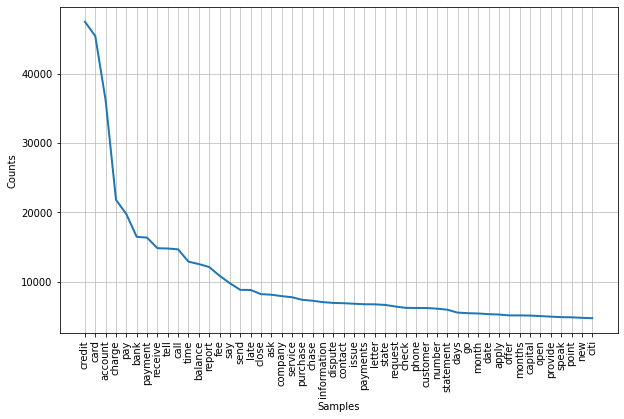

In [29]:
import nltk

# visualise word frequency
# flatten list of lists into 1D list
flat_list = [item for sublist in preprocessed_corpus for item in sublist]

print(len(flat_list))
# convert text to nltk text object
text = nltk.Text(flat_list)

# frequency of words
fdist = nltk.FreqDist(text)
print(fdist.most_common(50))
plt.figure(figsize=(10,6))
fdist.plot(50)

## Building a bag of words corpus and dictionary

Next we need to process our preprocessed data into a bag-of-words corpus and associated dictionary. The bag-of-words model is a simplified representation of text as a set of words and their frequency in a document.

For instance:
```
  Text: "John likes movies. Mary likes movies too."

  BoW Dictionary : {"John":1,"Mary":2,"likes":3,"movies":4,"too":5}

  BoW representation of text : [(1, 1), (2,1), (3,2), (4,2), (5,1)]
  (word_id, word_count)
```

This representation of the dictionary and the corpus can be used as the input into our topic model.



In [22]:
import numpy as np
from gensim.corpora import Dictionary

def bag_of_word_processing(corpus_of_tokens, lower_extreme, upper_extreme):
    """
    Take the list of tokens and convert them into a bag-of-words (BoW) format.

    Extended description of function.

    :param list of lists corpus_of_tokens: a list of strings produced during preprocessing representing all documents in corpus
    :param int lower_extreme: Description of arg2.
    :param float upper_extreme: the upper extreme filter limit, words are excluded if they occur in more documents than the proportion specified here
    :return: gensim.corpora.dictionary.Dictionary object 
    :return: list representing BoW corpus
    
    """

    # Create a dictionary representation of the documents.
    # gensim Dictionary function creates tokens -> tokenID dict
    dictionary = Dictionary(corpus_of_tokens)
    print('Number of unique words in initital documents:', len(dictionary))

    org_dict = len(dictionary)

    # Filter out words that occur less than 10 documents, or more than 70% of the documents.
    dictionary.filter_extremes(no_below=lower_extreme, no_above=upper_extreme)
    print('Number of unique words after removing rare and common words:', len(dictionary))

    filt_dict = len(dictionary)

    print('Token reduction of: ' + str((1-filt_dict/org_dict)*100)+'%')

    # transform to bag of words
    corpus = [dictionary.doc2bow(doc) for doc in corpus_of_tokens]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # output on document length
    print('Average number of words per document before BoW transform: ', np.mean([len(item) for item in preprocessed_corpus]))
    print('Average number of words per BoW document: ',np.mean([len(corpus[i]) for i in range(len(corpus))]))

    return dictionary, corpus

In [23]:
# create our BoW dictionary and corpus for use in LDA
working_dict, working_corpus = bag_of_word_processing(preprocessed_corpus, 10, 0.7)

Number of unique words in initital documents: 18111
Number of unique words after removing rare and common words: 4020
Token reduction of: 77.80354480702336%
Number of unique tokens: 4020
Number of documents: 18838
Average number of words per document before BoW transform:  78.1055313727572
Average number of words per BoW document:  46.33570442722157


## Building the topic model

We now have processed our initial texts into components that machines can interact with and we're ready to create a topic model!

In [24]:
# create a function to perform a scan of possible topic numbers 
# calculating the coherence score to determine model fitness
from gensim.models import CoherenceModel, ldamulticore

def long_topic_scan(dictionary, corpus,  texts, limit, start=2, step=3):
    """
    Identify the topic number with the highest coherence score out of a broad range of numbers
    Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts (doc_clean)
    limit : Max num of topics
    start : int starting topic number
    step : int increment from one topic number to another until limit is reached
    Returns:
    coherence_df : pd.DataFrame containing topic number and its calculated coherence score
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    graphical outputs
    """
    coherence_dict = dict()

    for num_topics in range(start, limit, step):
        model = ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=2)
        coherencemodel1 = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_dict[num_topics] = coherencemodel1.get_coherence()

    coherence_df = pd.DataFrame(pd.Series(coherence_dict)).reset_index()

    coherence_df.columns = ['Num_topics','Coherence_score']

    # Show graph
    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot(coherence_df['Num_topics'], coherence_df['Coherence_score'])
    ax.set_xlabel("No. of topics", fontweight='bold')
    ax.set_ylabel("Cv Coherence score", fontweight='bold')
    ax.axvline(coherence_df[coherence_df['Coherence_score'] == coherence_df['Coherence_score'].max()]['Num_topics'].tolist(), color='red')

    return coherence_df

CPU times: user 8min, sys: 10.9 s, total: 8min 11s
Wall time: 10min 9s


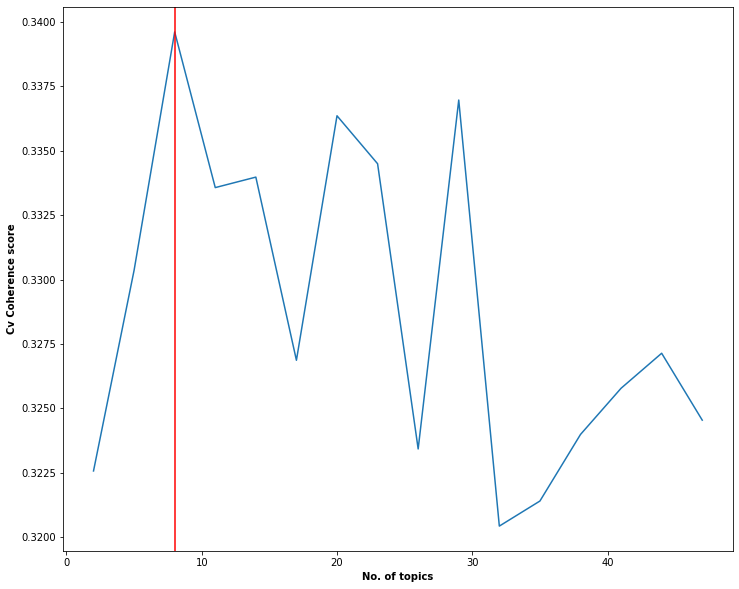

In [25]:
%%time

coh_model = long_topic_scan(working_dict, working_corpus, preprocessed_corpus, limit=50, step=3, start=2)

In [26]:
coh_model.sort_values(ascending = False, by='Coherence_score').head(1)

,Num_topics,Coherence_score
2,8,0.339619


In [30]:
# next we build our working model using the topic number we've determined

working_model = ldamulticore.LdaMulticore(corpus=working_corpus, num_topics=8, id2word=working_dict, workers=2)

coherencemodel1 = CoherenceModel(model=working_model, texts=preprocessed_corpus, dictionary=working_dict, coherence='c_v')

In [31]:
# our working models cv coherence score
coherencemodel1.get_coherence()

0.3299784339636186

In [32]:
# show the top 10 most probable words within each of the topics
working_model.show_topics(-1)

[(0,
  '0.028*"chase" + 0.021*"receive" + 0.019*"dispute" + 0.018*"payment" + 0.017*"service" + 0.016*"late" + 0.014*"charge" + 0.012*"account" + 0.010*"date" + 0.010*"call"'),
 (1,
  '0.031*"fee" + 0.030*"pay" + 0.027*"charge" + 0.027*"account" + 0.019*"balance" + 0.016*"payment" + 0.014*"late" + 0.013*"time" + 0.013*"tell" + 0.011*"receive"'),
 (2,
  '0.032*"payment" + 0.021*"balance" + 0.018*"pay" + 0.015*"bank" + 0.013*"rate" + 0.013*"payments" + 0.011*"time" + 0.010*"statement" + 0.010*"call" + 0.010*"account"'),
 (3,
  '0.024*"charge" + 0.021*"tell" + 0.019*"call" + 0.016*"bank" + 0.015*"say" + 0.012*"pay" + 0.010*"time" + 0.010*"ask" + 0.009*"receive" + 0.009*"account"'),
 (4,
  '0.029*"account" + 0.022*"report" + 0.014*"call" + 0.013*"receive" + 0.013*"tell" + 0.011*"payment" + 0.011*"balance" + 0.010*"pay" + 0.009*"send" + 0.009*"bank"'),
 (5,
  '0.049*"account" + 0.021*"bank" + 0.016*"charge" + 0.015*"payment" + 0.015*"pay" + 0.013*"close" + 0.012*"capital" + 0.010*"payments"

In [33]:
# install pyLDAvis library
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.5MB/s 
     |████████████████████████████████| 552kB 31.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=82957d422af860971b8a03f203aea54a93e4c866c6eb42c29fca77e89dec0f2b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=c4316a607c5d52bc36e8c4f8a6f90f8c5a73636ffd2ca7f16b91756954154ef6
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [34]:
# visualise the LDA model and topic distance using pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(working_model, working_corpus, dictionary=working_model.id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.008967 -0.034459       1        1  16.566589
4     -0.001906  0.012568       2        1  16.498562
1      0.032224 -0.001062       3        1  14.899456
5      0.009615  0.021336       4        1  13.708011
6     -0.036232 -0.011422       5        1  11.218267
2      0.063056  0.018571       6        1  10.150572
7     -0.052240  0.044367       7        1   9.273939
0     -0.005550 -0.049898       8        1   7.684600, topic_info=        Term          Freq         Total Category  logprob  loglift
361      fee   9978.000000   9978.000000  Default  30.0000  30.0000
152    chase   7865.000000   7865.000000  Default  29.0000  29.0000
71   payment  16525.000000  16525.000000  Default  28.0000  28.0000
2    account  34014.000000  34014.000000  Default  27.0000  27.0000
10   balance  11912.000000  11912.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
136  company    578.047974   8248.698242   Topic8  -5.1863  -0.0922
221     tell    688.072083  14659.355469   Topic8  -5.0120  -0.4930
102     bank    671.988892  16979.958984   Topic8  -5.0357  -0.6636
130    state    525.914612   6516.405762   Topic8  -5.2808   0.0490
17     check    498.469025   5981.747559   Topic8  -5.3344   0.0810

[646 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1531      1  0.036717  aadvantage
1531      2  0.119332  aadvantage
1531      3  0.146870  aadvantage
1531      4  0.055076  aadvantage
1531      5  0.559941  aadvantage
...     ...       ...         ...
3172      8  0.021477        yell
4006      1  0.824527       zales
4006      2  0.037479       zales
4006      3  0.074957       zales
4006      4  0.037479       zales

[2911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 6, 7, 3, 8, 1])

In [35]:
# create a dataframe of each document, its dominant topic, 
# its dominant topics score, the topic key words and the original text
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    # enumerate each topic and return number of topic, row of topic numbers and probabilities
    for row in ldamodel[corpus]:
        # sort row data into descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        # split row value into j (numerated), topic number, topic probability
        # select top numerated (top ranked topic), retrieve topic text and join it altogether
        # combine into pandas dataframe with topic text and probability of topic
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wordprob = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wordprob])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1,
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # add column names
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original text']

    return sent_topics_df

In [36]:
topic_df = format_topics_sentences(working_model, working_corpus, ticket_data["Consumer complaint narrative"].tolist())

In [39]:
# create dataframe of top 3 most representative docs for each topic

def get_top3_docs(dominant_topic_frame):

    table_lst = []

    # create dataframe of top 3 most representative docs for each topic
    for i in range(1, int(dominant_topic_frame['Dominant_Topic'].max())):
        # get indexes
        indy = dominant_topic_frame[dominant_topic_frame['Dominant_Topic'] == i].sort_values(by='Perc_Contribution', ascending=False).index.tolist()
        # test how many documents passed
        if len(indy) <= 3:
            for idx in indy:
                table_lst.append(dominant_topic_frame.iloc[idx, :])
        else:
            table_lst.append(dominant_topic_frame.iloc[indy[0], :])
            table_lst.append(dominant_topic_frame.iloc[indy[1], :])
            table_lst.append(dominant_topic_frame.iloc[indy[2], :])

    new_eg_df = pd.DataFrame(table_lst)

    return new_eg_df

In [40]:
# create a dataframe of the top 3 example documents of each dominant topic

top3_df = get_top3_docs(topic_df)

In [42]:
# print out the top 3 documents for each dominant topic for inspection

for topic in top3_df.Dominant_Topic.unique():
    
    print(f"Topic number {topic}")
    print(top3_df[top3_df.Dominant_Topic == topic].Topic_Keywords.tolist()[0], '\n')
    
    subset_df = top3_df[top3_df.Dominant_Topic == topic]['Original text'].tolist()
    
    for idx, item in enumerate(subset_df):
        print("text ", str(idx))
        print(item, '\n')
    
    print("----------")

Topic number 1.0
chase, receive, dispute, payment, service, late, charge, account, date, call 

text  0
To Whom It May Concern : On XXXX XXXX, 2016 a letter ( see Chase Notification ) was sent to Chase which Chase received on XXXX XXXX, 2016 ( see Chase return receipt ). 
Chase did not respond to this letter and initiated dunning calls. 
On or about XXXX XXXX, 2016 Chase in response to a verbal comment, classified the charges as unauthorized and issued provisional credits. 
On XXXX XXXX, 2016 Chase posted a letter claiming that a benefit was received from those charges ( see Chase alleged benefit letter-XXXX and Chase alleged benefit letter-XXXX ) In XXXX XXXX, 2016 Chase called but we were out of the country. 
On XXXX XXXX, 2016 the letters Chase alleged benefit letterXXXX and Chase alleged benefit letterXXXX were received. 
Between XXXX XXXX, 2016 and XXXX XXXX, XXXX approximately 11 calls were made to Chase regarding this matter. 
On XXXX XXXX, 2016 a letter was sent to Chase ( see 

## Conclusion

This brief example of topic modelling shows how quickly we can start to cluster together text based documents.

This approach still requires careful preparation of the initial input data and often domain expertise to really derive critical insights.

This approach can also be combined with supervised approaches from session 1 to create another series of data variables than can be used to predict outcomes from.